## Health Care for All Case Study using Pandas

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

<b> loading cleaning data 

In [38]:
hk_df=pd.read_csv("hk_df_cleaned.csv")

In [39]:
hk_df.columns

Index(['state', 'gender', 'median_home_val', 'avg_fam_income',
       'avg_household_income', 'med_fam_income', 'median_household_income',
       'hvp1', 'per_capita_income', 'pobc2', 'avggift', 'domain', 'target_d',
       'med_fam_income_binned'],
      dtype='object')

<b> checking correlations between numerical variables

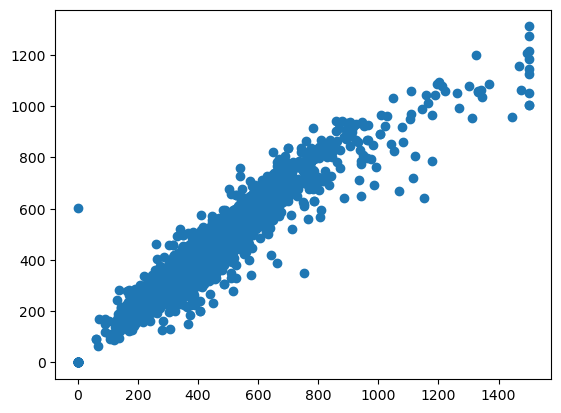

In [40]:
plt.scatter(x=hk_df['med_fam_income'], y=hk_df['avg_household_income'])
plt.show()

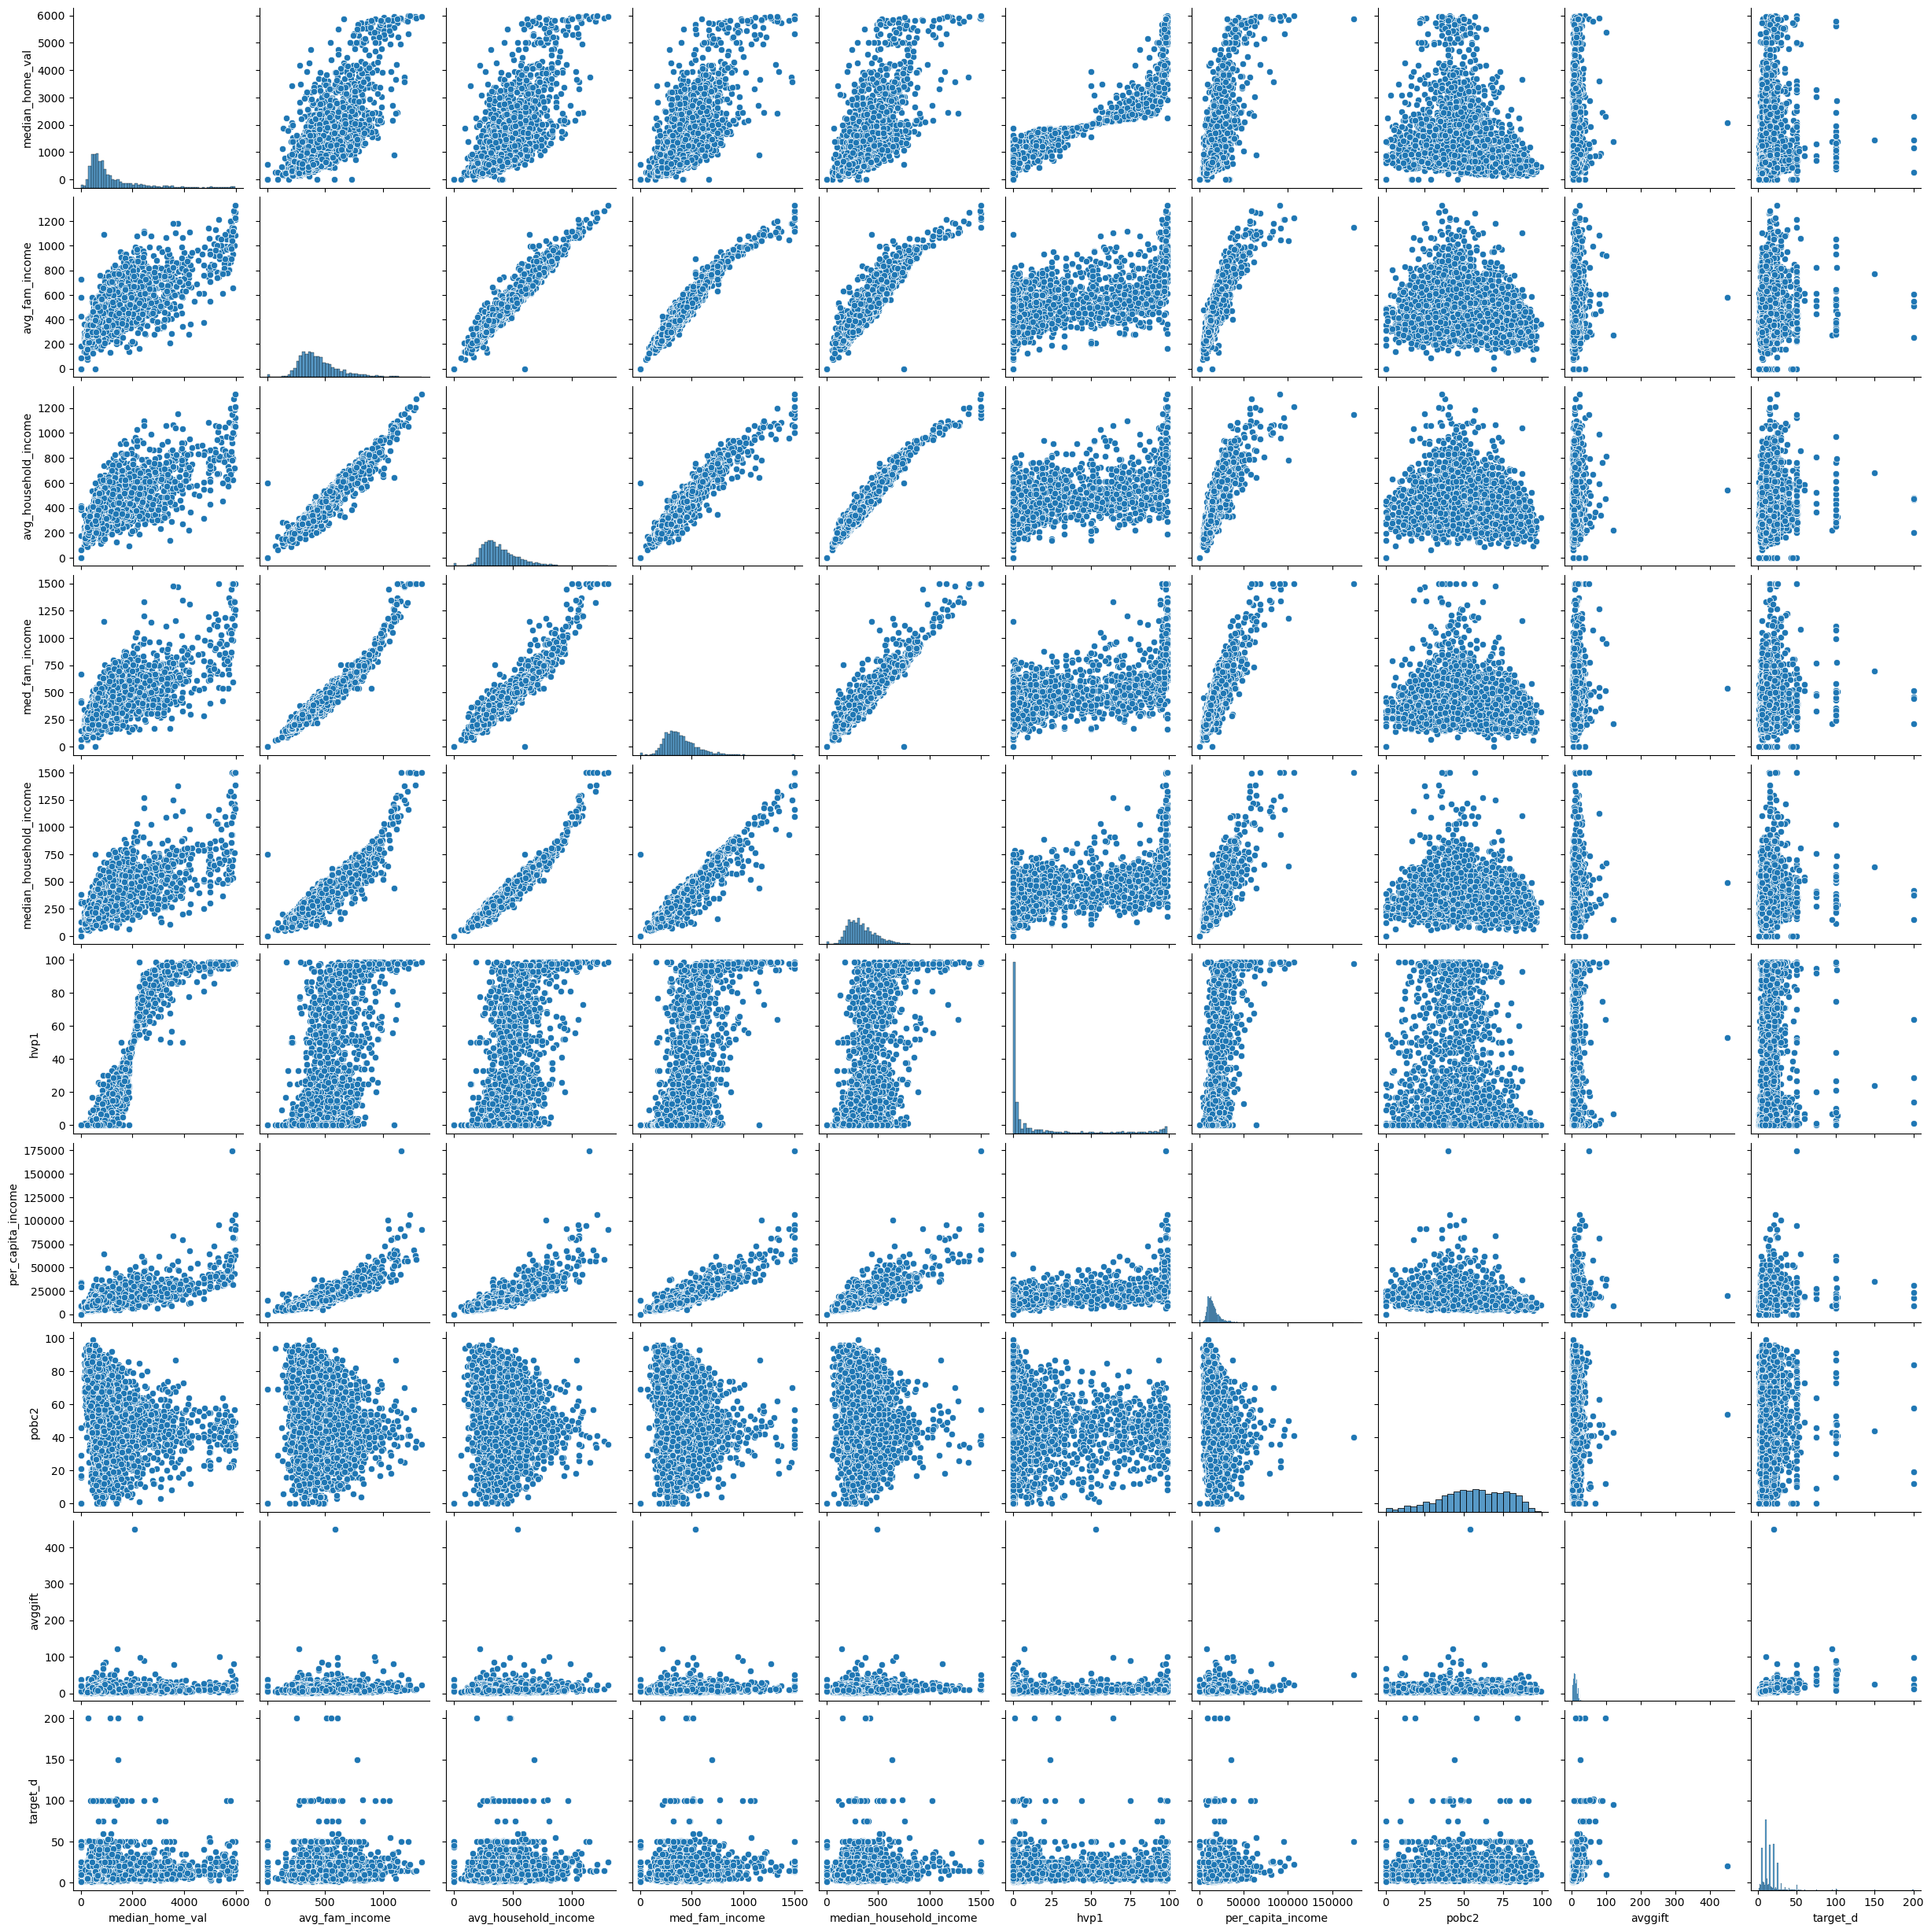

In [41]:
sns.pairplot(hk_df)

<b> plotting the correlation heatmap

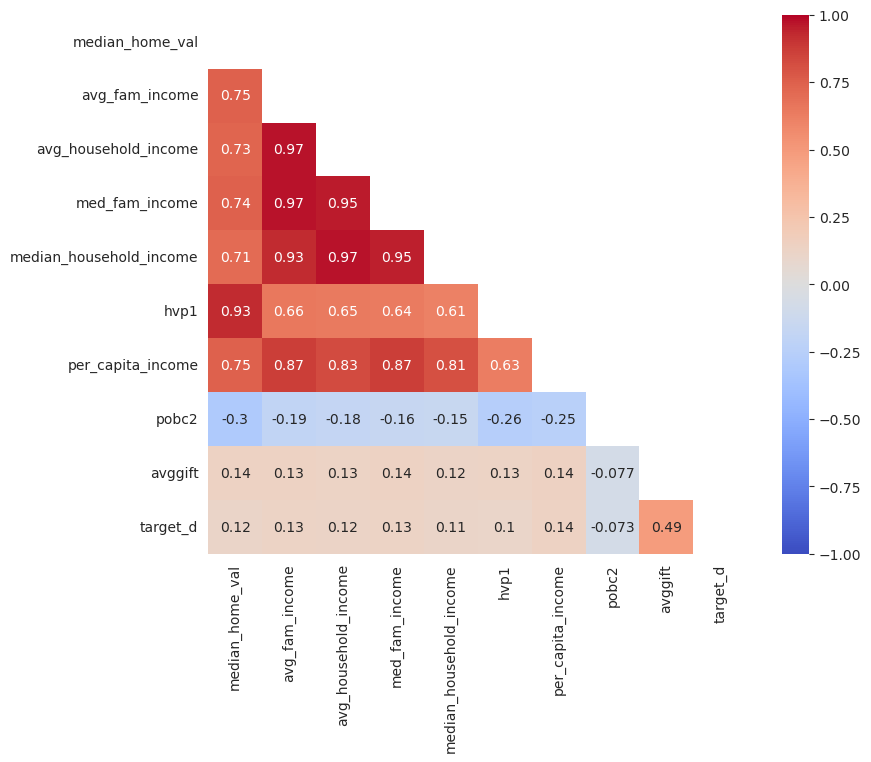

In [42]:
corr = hk_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

### Highly Correlated Columns

In [43]:
corr_matrix=hk_df.corr().abs()
upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
[column for column in upper_triangle.columns if any(upper_triangle[column] > 0.80)]

['avg_household_income',
 'med_fam_income',
 'median_household_income',
 'hvp1',
 'per_capita_income']

### dropping highly correlated features

In [44]:
hk_df.drop(["per_capita_income","hvp1","avg_household_income","median_household_income","med_fam_income"],axis=1,inplace=True)

In [45]:
hk_df

,state,gender,median_home_val,avg_fam_income,pobc2,avggift,domain,target_d,med_fam_income_binned
0,FL,Male,1159.148591,520.0,16,28,C2,100.0,Moderate
1,IL,Male,537.000000,473.0,89,5,T2,7.0,Moderate
2,FL,Female,725.000000,436.0,17,4,C2,5.0,Low
3,NC,Male,1159.148591,413.0,74,27,T2,38.0,Moderate
4,FL,Female,995.000000,348.0,6,6,C2,5.0,Low
...,...,...,...,...,...,...,...,...,...
4015,FL,Female,742.000000,470.0,37,14,S2,50.0,Moderate
4016,FL,Male,599.000000,423.0,27,9,C1,10.0,Moderate
4017,ND,Male,593.000000,299.0,70,5,S2,5.0,Low
4018,WI,Male,564.000000,397.0,96,11,T2,14.0,Moderate


array([[<AxesSubplot:title={'center':'median_home_val'}>,
        <AxesSubplot:title={'center':'avg_fam_income'}>],
       [<AxesSubplot:title={'center':'pobc2'}>,
        <AxesSubplot:title={'center':'avggift'}>],
       [<AxesSubplot:title={'center':'target_d'}>, <AxesSubplot:>]],
      dtype=object)

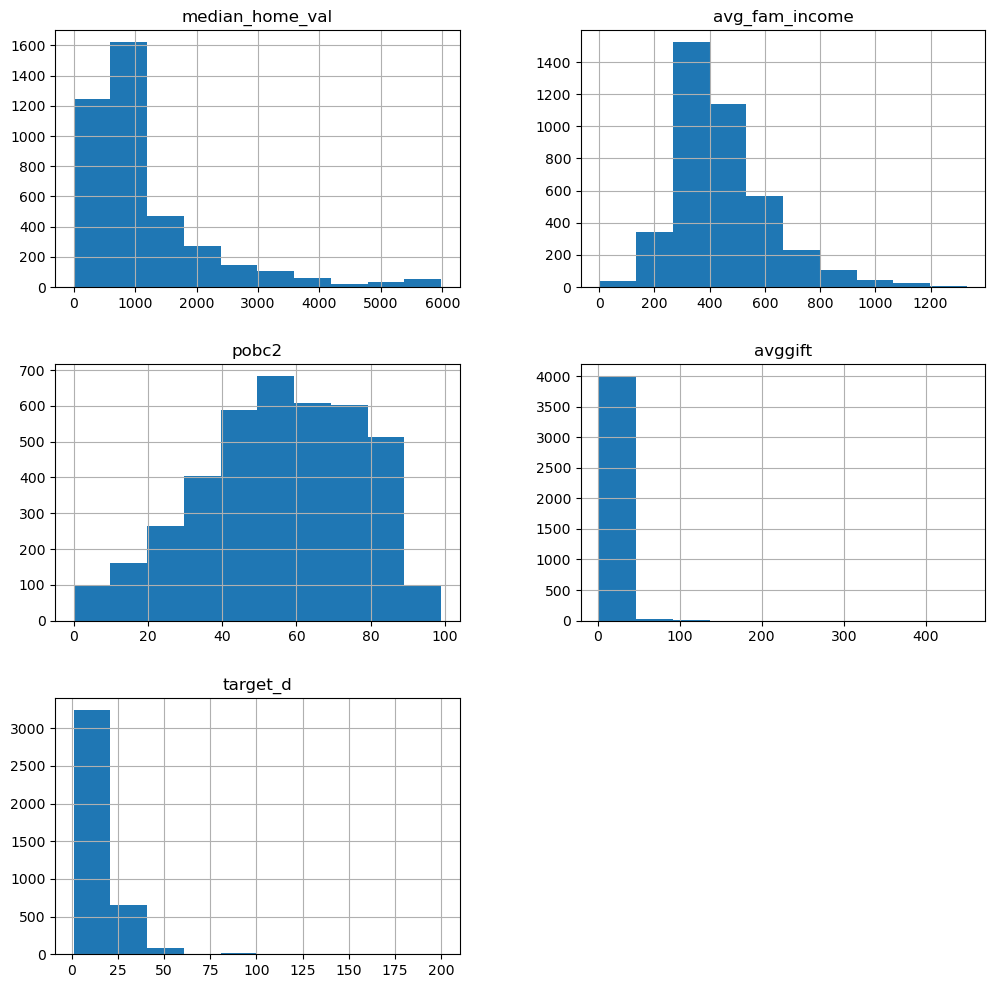

In [46]:
hk_df.hist(figsize=(12,12))

<b> checking the distribution plot

<AxesSubplot:xlabel='median_home_val', ylabel='Count'>

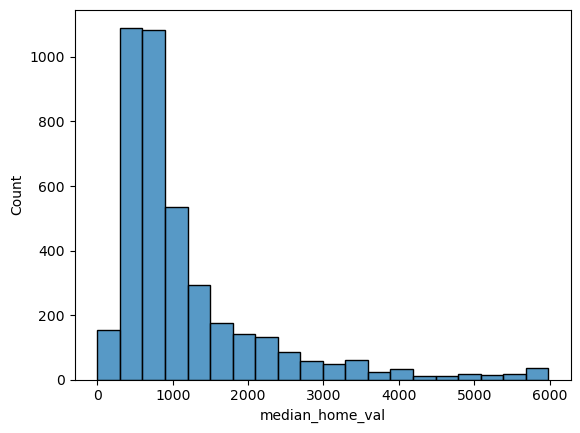

In [47]:
sns.histplot((hk_df['median_home_val']), bins=20)

## Data Transformation

Power Transformer: using power transformer to tranform the variable into normal distributionsas it is needed for modeling regression.

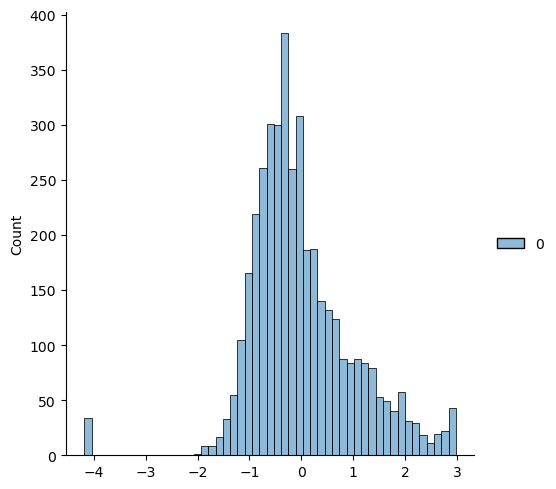

In [48]:
pt = PowerTransformer()
med_home_val_transformed=pt.fit_transform(hk_df['median_home_val'].to_numpy().reshape(-1,1))
sns.displot(med_home_val_transformed)

In [49]:
pt.lambdas_

array([0.24409374])

In [50]:
hk_df["med_home_val_transformed"]= med_home_val_transformed
hk_df.drop(["median_home_val"],axis=1,inplace=True)

In [51]:
hk_df

,state,gender,avg_fam_income,pobc2,avggift,domain,target_d,med_fam_income_binned,med_home_val_transformed
0,FL,Male,520.0,16,28,C2,100.0,Moderate,0.294846
1,IL,Male,473.0,89,5,T2,7.0,Moderate,-0.636833
2,FL,Female,436.0,17,4,C2,5.0,Low,-0.294111
3,NC,Male,413.0,74,27,T2,38.0,Moderate,0.294846
4,FL,Female,348.0,6,6,C2,5.0,Low,0.095725
...,...,...,...,...,...,...,...,...,...
4015,FL,Female,470.0,37,14,S2,50.0,Moderate,-0.266584
4016,FL,Male,423.0,27,9,C1,10.0,Moderate,-0.514993
4017,ND,Male,299.0,70,5,S2,5.0,Low,-0.526356
4018,WI,Male,397.0,96,11,T2,14.0,Moderate,-0.582535


## Hot coding Categorical Variables 

In [52]:
categoricals_features= hk_df.select_dtypes("object")
categoricals_features

,state,gender,domain,med_fam_income_binned
0,FL,Male,C2,Moderate
1,IL,Male,T2,Moderate
2,FL,Female,C2,Low
3,NC,Male,T2,Moderate
4,FL,Female,C2,Low
...,...,...,...,...
4015,FL,Female,S2,Moderate
4016,FL,Male,C1,Moderate
4017,ND,Male,S2,Low
4018,WI,Male,T2,Moderate


In [53]:
#hk_df.state.value_counts()
#hk_df.gender.value_counts()
#hk_df.domain.value_counts()

In [54]:
# categoricals_features[["gender"]].value_counts()
# data needs to be cleaned

In [55]:
categoricals_features=pd.get_dummies(categoricals_features[["gender"]], drop_first=True)
categoricals_features

,gender_Female,gender_Male
0,0,1
1,0,1
2,1,0
3,0,1
4,1,0
...,...,...
4015,1,0
4016,0,1
4017,0,1
4018,0,1


### Predictive Modeling

<b> X Y split

In [56]:
X=hk_df.drop('target_d', axis=1)
y=hk_df.target_d

In [57]:
X=X._get_numeric_data()
X

,avg_fam_income,pobc2,avggift,med_home_val_transformed
0,520.0,16,28,0.294846
1,473.0,89,5,-0.636833
2,436.0,17,4,-0.294111
3,413.0,74,27,0.294846
4,348.0,6,6,0.095725
...,...,...,...,...
4015,470.0,37,14,-0.266584
4016,423.0,27,9,-0.514993
4017,299.0,70,5,-0.526356
4018,397.0,96,11,-0.582535


In [58]:
## adding categorical features
#X=pd.concat([X,categorical_cols],axis=1)

array([[<AxesSubplot:title={'center':'avg_fam_income'}>,
        <AxesSubplot:title={'center':'pobc2'}>],
       [<AxesSubplot:title={'center':'avggift'}>,
        <AxesSubplot:title={'center':'med_home_val_transformed'}>]],
      dtype=object)

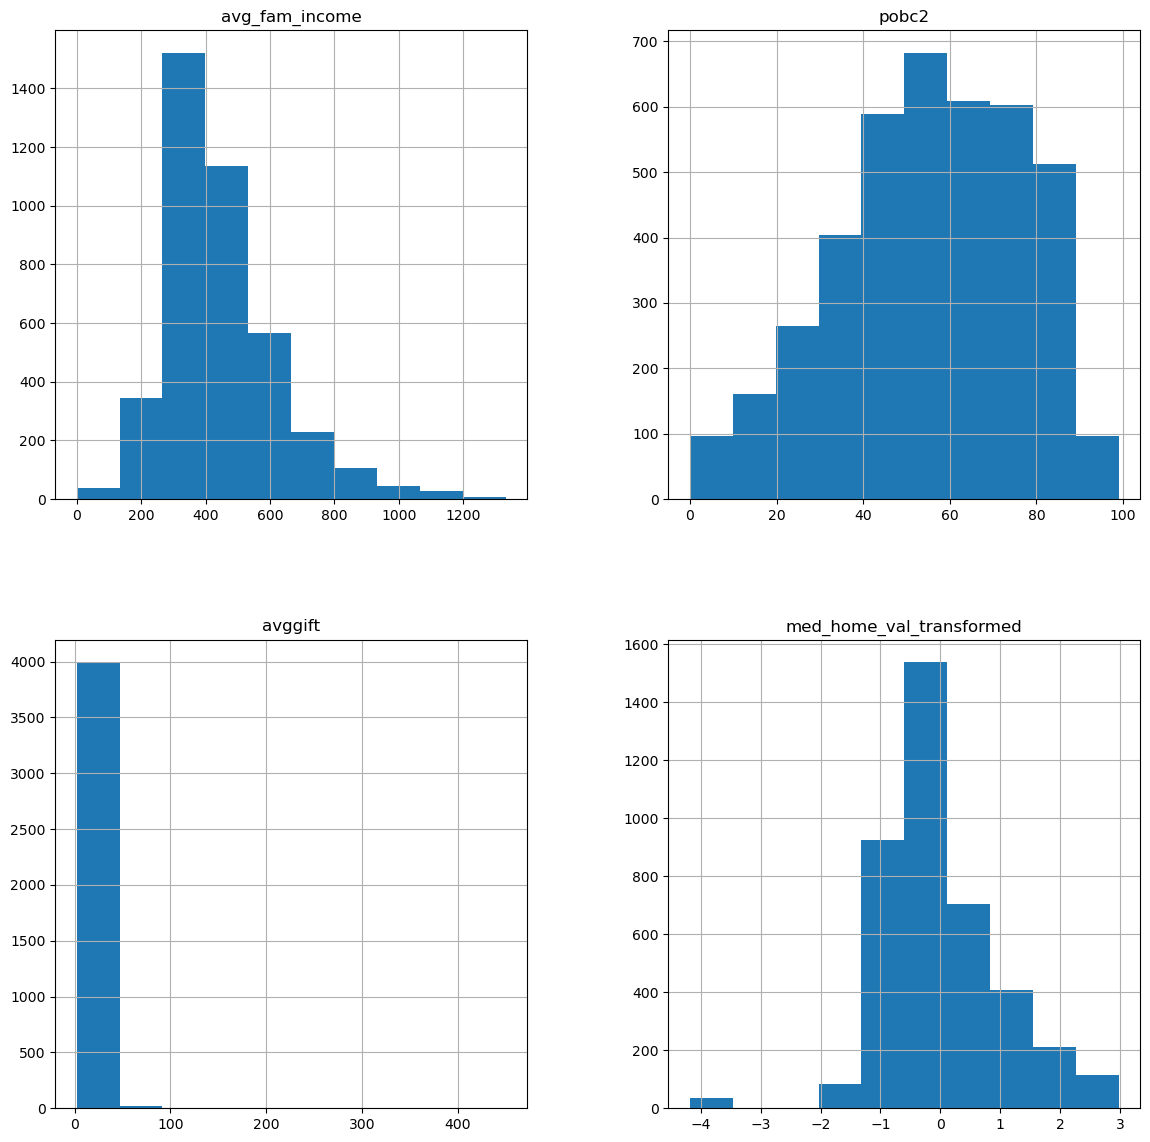

In [59]:
X.hist(figsize=(14,14))

<b>Data Splitting

In [60]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=123)

<b> Standardize 

In [61]:
std_scaler=StandardScaler().fit(X_train)   ##. finding the parameters ( mean, variance from the training set )

X_train_scaled=std_scaler.transform(X_train)

In [62]:
X_train.shape

(2814, 4)

In [63]:
X_test_scaled=std_scaler.transform(X_test)

In [64]:
print(X_train_scaled)
print("--------")
print(X_test_scaled)

[[-0.71897043  1.66154024 -0.39208054 -0.77537059]
 [-0.62656524 -0.70762673 -0.39208054 -0.44419585]
 [ 0.68443342 -0.70762673 -0.30251851  1.22079047]
 ...
 [ 1.08870613 -1.07926076 -0.39208054  0.11184797]
 [-0.91533146  0.82536366 -0.21295648 -1.25659466]
 [ 0.91544639  1.24345195  0.3244157   0.18915193]]
--------
[[-0.88067952 -0.28953844 -0.57120461 -0.70072513]
 [ 0.04914772 -1.59025756 -0.66076664  0.1067388 ]
 [-0.83447692  0.40727538  1.220036   -0.45684691]
 ...
 [ 0.35523992 -1.12571501  0.14529164 -0.09122577]
 [-0.69586913  1.33636046 -0.30251851 -0.56400389]
 [-0.32624837 -2.10125435  0.3244157  -0.1042373 ]]


## Apply Linear Regression

### Modeling using Statsmodels

In [65]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               target_d   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     178.9
Date:                Thu, 27 Oct 2022   Prob (F-statistic):          1.02e-136
Time:                        14:54:09   Log-Likelihood:                -10819.
No. Observations:                2814   AIC:                         2.165e+04
Df Residuals:                    2809   BIC:                         2.168e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.6046      0.213     73.115      0.0

In [66]:
predictions_test

array([11.76506942, 12.67316886, 21.19269151, ..., 17.38547977,
       12.73877306, 17.85812167])

In [67]:
#display adjusted R-squared
print(model.rsquared_adj)

0.20192590006837352


### Modeling using Scikit Learn

Model fitting

In [68]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

<b> model parameters  ( b1,b2,b3,b4)

In [69]:
X_train

,avg_fam_income,pobc2,avggift,med_home_val_transformed
799,319.0,91,7,-0.769799
3277,335.0,40,7,-0.439561
486,562.0,40,8,1.220714
2868,340.0,14,13,-0.338849
949,610.0,33,15,0.145162
...,...,...,...,...
1122,389.0,81,13,-0.598415
1346,428.0,88,7,-0.486957
3454,632.0,32,7,0.114910
3437,285.0,73,9,-1.249661


In [70]:
model.coef_

array([ 1.34329297, -0.41463578,  5.45586257, -0.48499692])

In [71]:
model.intercept_

15.60459132906894

In [72]:
#y= 1.34* avg_fam_income  -0.41 * pobc2   +5.45 * avggift  -0.48 * med_home_val_transformed  + 15.66

Making prediction

In [73]:
y_pred=model.predict(X_test_scaled)   # model prediction

y_pred_train=model.predict(X_train_scaled)

In [74]:
y_pred

array([11.76506942, 12.67316886, 21.19269151, ..., 17.38547977,
       12.73877306, 17.85812167])

In [75]:
y_test

2160     5.0
627      4.0
2261    20.0
822     25.0
198      3.0
        ... 
2708    25.0
336      7.0
1757    38.0
1801    10.0
1499    15.0
Name: target_d, Length: 1206, dtype: float64

## predicting on new data

In [77]:
# np.array(np.array(new_data).reshape(-1,4)).shape

In [78]:
## new record 
new_data=[400,80,12,0.15]
new_data_scaled=std_scaler.transform(np.array(new_data).reshape(-1,4))

/Users/hauke/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [79]:
model.predict(new_data_scaled)

array([15.02288121])

## Evaluating Model Performance

In [80]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

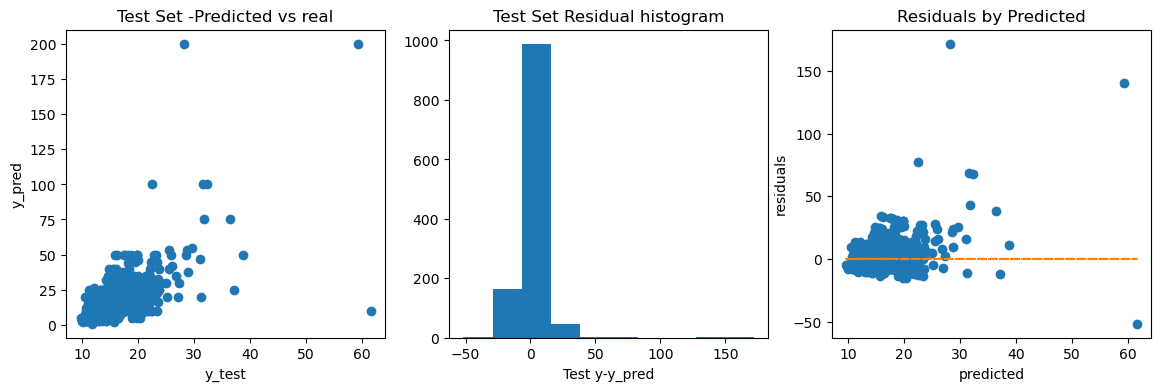

In [81]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<b>more fancy using seaborn

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

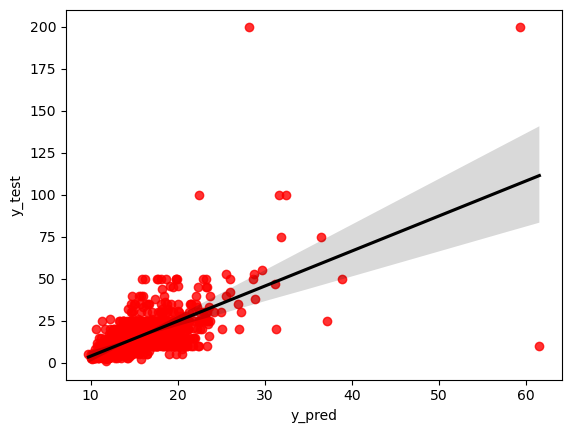

In [82]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

<b> Error metrics

In [124]:
print(mse(y_test,y_pred_test))
print(mae(y_test,y_pred_test))

110.98918918136913
5.973471711751965


In [125]:
##prediction on the train set
mse(y_train,y_pred_train)

127.95043838874163

In [126]:
R2=r2_score(y_test,y_pred)
R2

0.3121860303724322

In [127]:
R2_test=model.score(X_test_scaled,y_test)
R2_train=model.score(X_train_scaled,y_train)

In [238]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.31029012796646827

## getting the number of parameters 

In [128]:
X_test.shape[1]

4

#### Feature Importance

In [129]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

In [130]:
features_importances

,Attribute,Importance
2,avggift,5.455863
0,avg_fam_income,1.343293
3,med_home_val_transformed,0.484997
1,pobc2,0.414636


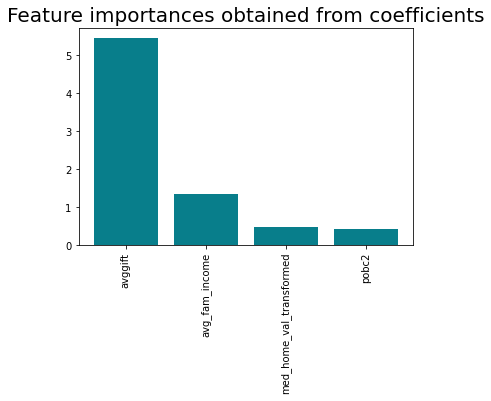

In [131]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

#### Write a csv

With `to_csv` 

In [132]:
hk_df.to_csv("Data/healthcare_for_all_transformed_data.csv")